<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/2021_11_01_detertor_with_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
! git clone https://github.com/josooik/Face-detection-for-DSM

fatal: destination path 'Face-detection-for-DSM' already exists and is not an empty directory.


In [19]:
import cv2, sys
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Detect_Flow()

In [20]:
def detect_flow(imgPath, modelDir):
    
    # read image
    img = cv2.imread(imgPath)
    (img_h, img_w) = img.shape[:2]
    print("* org img shape:", imgPath,  img.shape)
    
    # use model
    facenet = cv2.dnn.readNet(modelDir+"/deploy.prototxt",
                              modelDir+"/res10_300x300_ssd_iter_140000.caffemodel")
    
    blob = cv2.dnn.blobFromImage( img, 
                                  1.0, (300, 300),
    	                          (104.0, 177.0, 123.0))
    facenet.setInput(blob)
    detections = facenet.forward()
    print("* dections results:", detections.shape)
   
    # get results from detections
    faces=[]
    for i in range(detections.shape[2]):
      conf = detections[0,0,i,2]
      if conf <0.5:
        continue
      x1 = int(detections[0,0,i,3]*img_w)
      y1 = int(detections[0,0,i,4]*img_h)
      x2 = int(detections[0,0,i,5]*img_w)
      y2 = int(detections[0,0,i,6]*img_h)
      cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    
      #얼굴만 크롭하기
     
      faces.append([x1,y1,x2,y2])
    
    # visualize
    cv2_imshow(img)
    return faces

* org img shape: Face-detection-for-DSM/imgs/01.jpg (349, 620, 3)
* dections results: (1, 1, 200, 7)


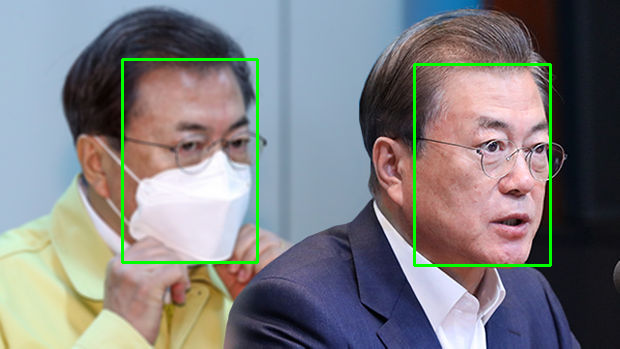

In [21]:
imgPath = 'Face-detection-for-DSM/imgs/01.jpg'
modelDir = 'Face-detection-for-DSM/models'

#for i in imgPath:
faces_ax = detect_flow(imgPath, modelDir)

In [22]:
img = cv2.imread(imgPath)
faces=[]
for x1, y1, x2, y2 in faces_ax:
  face= img[y1:y2,x1:x2]
  faces.append(face)

(201, 136, 3)
(203, 135, 3)


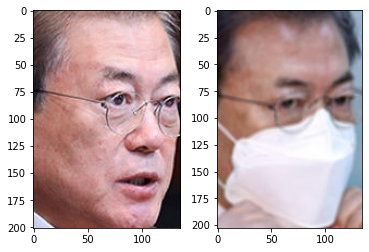

In [23]:
for i, face in enumerate(faces):
  print(face.shape)
  plt.subplot(1,len(faces),i+1)
  plt.imshow(cv2.cvtColor(face,cv2.COLOR_BGR2RGB))
  
plt.show()

In [24]:
from tensorflow.keras import applications, utils, layers, models, optimizers

In [25]:
faces_pre = []

for face in faces:
  face = cv2.resize(face, (224, 224))
  face = applications.mobilenet_v2.preprocess_input(face)
  faces_pre.append(face)
  print(face.shape)

(224, 224, 3)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
(224, 224, 3)


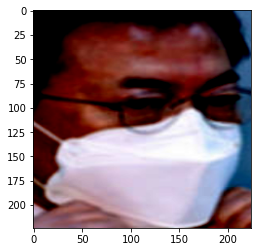

In [26]:
for face in faces_pre:
  print(face.shape)
  plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.show()

In [27]:
from tensorflow.keras import models

model_cfy = models.load_model("Face-detection-for-DSM/models/mask_model.h5")

In [28]:
faces_pre = np.array(faces_pre)
faces_pre.shape

(2, 224, 224, 3)

In [29]:
results = model_cfy.predict(faces_pre)

print("faces_pre_predict = ", model_cfy.predict(faces_pre))

faces_pre_predict =  [[2.2710246e-04 9.9977285e-01]
 [9.9960607e-01 3.9400376e-04]]


# Visualize

In [30]:
face.shape

(224, 224, 3)

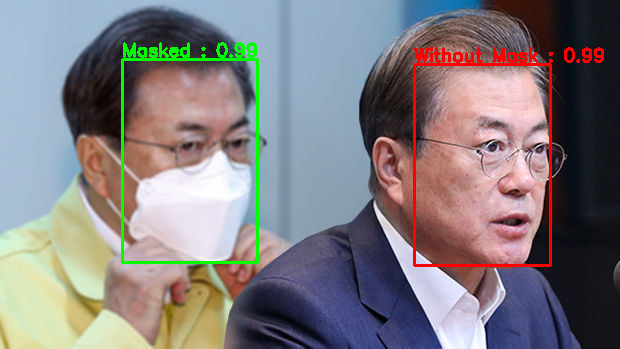

p_mask :  0.9996061
p_without_mask :  0.00039400376


In [34]:
img = cv2.imread(imgPath)

for i, ax in enumerate(faces_ax):
  res_1 = results[i]

  p_mask = res_1[0]
  p_without_mask = res_1[1]

  if p_mask > p_without_mask:
    color = (0,255,0)
    label = "Masked" + " : " + str(p_mask)[:4]

  else:
    color = (0, 0, 255)
    label = "Without Mask" + " : " + str(p_without_mask)[:4]

  cv2.putText(img, label, (ax[0], ax[1]-3),cv2.FONT_HERSHEY_SIMPLEX,0.6,color,2)
  cv2.rectangle(img, (ax[0], ax[1]), (ax[2], ax[3]), color, 2)

cv2_imshow(img)

print("p_mask : ", p_mask)
print("p_without_mask : ", p_without_mask)